In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/file-srt/Dataset srt/R/M3GAN.2022.1080p.WEB.H264-NAISU.srt
/kaggle/input/file-srt/Dataset srt/R/John.Wick.Chapter.3.Parabellum.2019.720p.BluRay.x264-.YTS.LT.-HI.srt
/kaggle/input/file-srt/Dataset srt/R/The.Voyeurs.2021.1080p.AMZN.WEB-DL.DDP5.1.H.264-CMRG-HI.srt
/kaggle/input/file-srt/Dataset srt/R/Anora.2024.1080p.AMZN.WEB-DL.DDP5.1.H.264-FLUX.srt
/kaggle/input/file-srt/Dataset srt/R/The.Medium.2021.1080p.WEB-DL.x264.srt
/kaggle/input/file-srt/Dataset srt/R/Insidious.The.Red.Door.2023.720p.BluRay.x264.AAC.srt
/kaggle/input/file-srt/Dataset srt/R/Curse.of.the.Witchs.Doll.2018.HDRip.XviD.AC3-EVO-HI.srt
/kaggle/input/file-srt/Dataset srt/R/Challengers.2024.1080p.AMZN.WEB-DL.DDP5.1.Atmos.H.264-FLUX.srt
/kaggle/input/file-srt/Dataset srt/R/A.Star.is.Born.2018.720p.BluRay.DD5.1.X264-iFT-HI.srt
/kaggle/input/file-srt/Dataset srt/R/Fifty Shades Freed.2018.HDRip.XviD.AC3-EVO.srt
/kaggle/input/file-srt/Dataset srt/R/Destination.Wedding.2018.720p.BluRay.x264-VETO.srt
/kaggle/input/f

In [2]:
!pip install nltk tqdm --upgrade

In [3]:
# Cell 0a: Checking Kaggle Environment and Paths
print("Current directory:", os.getcwd())
print("Available files:", os.listdir())
print("System information:", os.uname() if hasattr(os, 'uname') else "Not available")

# Try to list Kaggle input directory
try:
    input_dir = "/kaggle/input"
    if os.path.exists(input_dir):
        print(f"Kaggle input directory contents: {os.listdir(input_dir)}")
        for dataset_dir in os.listdir(input_dir):
            dataset_path = os.path.join(input_dir, dataset_dir)
            if os.path.isdir(dataset_path):
                print(f"  - {dataset_dir} contents: {os.listdir(dataset_path)}")
    else:
        print("No Kaggle input directory found")
except Exception as e:
    print(f"Error accessing Kaggle input: {e}")

# Check for required libraries
for lib in ['pandas', 'numpy', 'sklearn', 'nltk']:
    try:
        exec(f"import {lib}")
        print(f"{lib} successfully imported")
    except Exception as e:
        print(f"Error importing {lib}: {e}")

# Cell 0b: Use Try-Except for safer execution
# This allows for better debugging if something goes wrong
try:
    # Check if there are any .srt files in the current or subdirectories
    all_srt_files = glob.glob('**/*.srt', recursive=True)
    print(f"Found {len(all_srt_files)} .srt files in current directory and subdirectories")
    if len(all_srt_files) > 0:
        print("Sample .srt files:", all_srt_files[:5])
        
    # Check for keywords.csv
    if os.path.exists('keywords.csv'):
        print("keywords.csv found in current directory")
        # Peek at the file
        try:
            with open('keywords.csv', 'r', encoding='utf-8') as f:
                print("First 5 lines of keywords.csv:")
                for i, line in enumerate(f):
                    if i < 5:
                        print(line.strip())
                    else:
                        break
        except Exception as e:
            print(f"Error reading keywords.csv: {e}")
except Exception as e:
    print(f"Error in environment checking: {e}")

Current directory: /kaggle/working
Available files: ['.virtual_documents']
System information: posix.uname_result(sysname='Linux', nodename='819914f6111e', release='6.6.56+', version='#1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024', machine='x86_64')
Kaggle input directory contents: ['file-srt', 'kata-update']
  - file-srt contents: ['Dataset srt']
  - kata-update contents: ['keywords_updated.csv']
pandas successfully imported
numpy successfully imported
sklearn successfully imported
nltk successfully imported
Error in environment checking: name 'glob' is not defined


In [5]:
import pandas as pd
import numpy as np
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import glob
import joblib
import warnings
warnings.filterwarnings('ignore')

# Download NLTK resources silently
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
except Exception as e:
    print(f"Warning: Cannot download NLTK resources: {e}")

# Mencari file keywords dan direktori dataset
def find_paths():
    # Path potensial untuk file keywords
    keyword_paths = [
        "/kaggle/input/kata-update/keywords_updated.csv",
        "keywords.csv",
        "data/keywords.csv",
        "../data/keywords.csv"
    ]
    
    # Path potensial untuk direktori dataset
    data_paths = [
        "/kaggle/input/file-srt/Dataset srt",
        "dataset",
        "data",
        "../dataset"
    ]
    
    # Cari file keywords
    keywords_path = None
    for path in keyword_paths:
        if os.path.exists(path):
            keywords_path = path
            print(f"File keywords ditemukan: {path}")
            break
    
    # Cari direktori dataset
    base_dir = None
    for path in data_paths:
        if os.path.exists(path):
            base_dir = path
            print(f"Direktori dataset ditemukan: {path}")
            break
    
    return keywords_path, base_dir

# Load file .srt
def load_file(file_path):
    try:
        if file_path.endswith('.srt'):
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                content = f.read()
            return content
        # Masih mendukung file lain, tapi tidak diprioritaskan
        elif file_path.endswith('.txt'):
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                content = f.read()
            return content
        elif file_path.endswith('.csv'):
            return pd.read_csv(file_path, engine='python', on_bad_lines='skip')
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

# Load keywords CSV dengan dukungan berbagai format kolom
def load_keywords(file_path):
    try:
        if not os.path.exists(file_path):
            print(f"Error: File '{file_path}' tidak ditemukan.")
            return None
        
        print(f"Membaca file keywords: {file_path}")
        
        # Baca file CSV
        keywords_df = pd.read_csv(file_path, engine='python', on_bad_lines='skip')
        
        # Pemetaan kolom
        col_mapping = {}
        
        # Cari kolom untuk 'teks'
        if 'teks' in keywords_df.columns:
            col_mapping['teks'] = 'teks'
        elif 'text' in keywords_df.columns:
            col_mapping['teks'] = 'text'
        elif 'kata' in keywords_df.columns:
            col_mapping['teks'] = 'kata'
        elif 'keyword' in keywords_df.columns:
            col_mapping['teks'] = 'keyword'
        elif 'word' in keywords_df.columns:
            col_mapping['teks'] = 'word'
        else:
            # Asumsikan kolom pertama adalah 'teks'
            col_mapping['teks'] = keywords_df.columns[0]
            print(f"Menggunakan kolom '{col_mapping['teks']}' sebagai 'teks'")
        
        # Cari kolom untuk 'kategori'
        if 'kategori' in keywords_df.columns:
            col_mapping['kategori'] = 'kategori'
        elif 'category' in keywords_df.columns:
            col_mapping['kategori'] = 'category'
        elif 'description' in keywords_df.columns:
            col_mapping['kategori'] = 'description'
        elif 'jenis' in keywords_df.columns:
            col_mapping['kategori'] = 'jenis'
        elif 'type' in keywords_df.columns:
            col_mapping['kategori'] = 'type'
        else:
            # Asumsikan kolom kedua adalah 'kategori'
            if len(keywords_df.columns) > 1:
                col_mapping['kategori'] = keywords_df.columns[1]
                print(f"Menggunakan kolom '{col_mapping['kategori']}' sebagai 'kategori'")
            else:
                print("Tidak dapat menemukan kolom untuk 'kategori'")
                return None
        
        # Cari kolom untuk 'severity'
        if 'severity' in keywords_df.columns:
            col_mapping['severity'] = 'severity'
        elif 'tingkat' in keywords_df.columns:
            col_mapping['severity'] = 'tingkat'
        elif 'level' in keywords_df.columns:
            col_mapping['severity'] = 'level'
        elif 'keparahan' in keywords_df.columns:
            col_mapping['severity'] = 'keparahan'
        else:
            # Asumsikan kolom ketiga adalah 'severity'
            if len(keywords_df.columns) > 2:
                col_mapping['severity'] = keywords_df.columns[2]
                print(f"Menggunakan kolom '{col_mapping['severity']}' sebagai 'severity'")
            else:
                print("Tidak dapat menemukan kolom untuk 'severity'")
                return None
        
        # Standardisasi nama kolom
        print(f"Pemetaan kolom: {col_mapping}")
        keywords_df.rename(columns={
            col_mapping['teks']: 'teks',
            col_mapping['kategori']: 'kategori',
            col_mapping['severity']: 'severity'
        }, inplace=True)
        
        # Bersihkan dan standardisasi data
        keywords_df['teks'] = keywords_df['teks'].astype(str)
        keywords_df['kategori'] = keywords_df['kategori'].astype(str).str.lower()
        keywords_df['severity'] = keywords_df['severity'].astype(str).str.lower()
        
        # Format standarisasi kategori (dihapus referensi ke 'drug')
        keywords_df['kategori'] = keywords_df['kategori'].replace({
            'sexual': 'sexual',
            'sex': 'sexual',
            'seksual': 'sexual',
            'bad language': 'bad language',
            'bad_language': 'bad language',
            'bahasa kasar': 'bad language',
            'violence': 'violence',
            'kekerasan': 'violence'
        })
        
        # Format standarisasi severity
        keywords_df['severity'] = keywords_df['severity'].replace({
            'mild': 'mild',
            'ringan': 'mild',
            'moderate': 'moderate',
            'sedang': 'moderate',
            'severe': 'severe',
            'berat': 'severe'
        })
        
        # Filter hanya kategori yang relevan (menghapus 'drug')
        valid_categories = ['bad language', 'sexual', 'violence']
        keywords_df = keywords_df[keywords_df['kategori'].isin(valid_categories)]
        
        # Periksa apakah kolom penting sudah ada
        if 'teks' in keywords_df.columns and 'kategori' in keywords_df.columns and 'severity' in keywords_df.columns:
            print(f"Berhasil memuat {len(keywords_df)} kata kunci")
            
            # Tampilkan sampel hasil konversi
            print("\nContoh kata kunci setelah konversi:")
            print(keywords_df[['teks', 'kategori', 'severity']].head(3))
            
            return keywords_df
        else:
            print("Gagal memetakan kolom yang dibutuhkan")
            return None
        
    except Exception as e:
        print(f"Error loading keywords: {e}")
        
        # Buat data keywords dummy sebagai fallback
        print("Membuat data keywords dummy sebagai fallback...")
        dummy_data = {
            'teks': ['fuck', 'shit', 'ass', 'damn', 'dick', 'sex', 'nude', 'kill', 'murder', 'fight'],
            'kategori': ['bad language', 'bad language', 'bad language', 'bad language', 'bad language', 
                      'sexual', 'sexual', 'violence', 'violence', 'violence'],
            'severity': ['severe', 'moderate', 'mild', 'mild', 'moderate', 
                      'moderate', 'moderate', 'severe', 'severe', 'moderate']
        }
        return pd.DataFrame(dummy_data)

def main():
    print("=== Film Content Rating Classification with MultinomialNB and dev_advance_features ===")
    
    # Find file paths
    keywords_path, base_dir = find_paths()
    
    if keywords_path is None or base_dir is None:
        print("Error: Could not find required files. Please check paths.")
        return

    # Load keywords
    keywords_df = load_keywords(keywords_path)
    
    if keywords_df is None:
        print("Error: Failed to load keywords.")
        return
    
    # Process files from directories - use all available files per rating
    features_df = process_files(base_dir, keywords_df)
    
    if features_df is None or len(features_df) == 0:
        print("Error: No files were processed successfully.")
        return

=== Film Content Rating Classification with MultinomialNB and dev_advance_features ===
File keywords ditemukan: /kaggle/input/kata-update/keywords_updated.csv
Direktori dataset ditemukan: /kaggle/input/file-srt/Dataset srt
Membaca file keywords: /kaggle/input/kata-update/keywords_updated.csv
Pemetaan kolom: {'teks': 'teks', 'kategori': 'kategori', 'severity': 'severity'}
Berhasil memuat 954 kata kunci

Contoh kata kunci setelah konversi:
       teks      kategori  severity
0      anus        sexual      mild
1      arse        sexual      mild
2  arsehole  bad language  moderate
Folder 'outputs' berhasil dibuat.
Found 60 .srt files in G folder


Processing G files: 100%|██████████| 60/60 [00:30<00:00,  1.94it/s]


Found 60 .srt files in PG folder


Processing PG files: 100%|██████████| 60/60 [00:31<00:00,  1.92it/s]


Found 60 .srt files in PG-13 folder


Processing PG-13 files: 100%|██████████| 60/60 [00:35<00:00,  1.71it/s]


Found 60 .srt files in R folder


Processing R files: 100%|██████████| 60/60 [00:29<00:00,  2.07it/s]


Added 33 advanced features

Dataset distribution:
actual_rating
G        60
PG       60
PG-13    60
R        60
Name: count, dtype: int64

Using full dataset for training: 240 samples

Using 27 content features

Extracting text features with TF-IDF...
Extracting content features...

Finding optimal hyperparameters for MultinomialNB...
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Best alpha value for MultinomialNB: 0.01
Cross-validation accuracy: 0.6542

Training MultinomialNB model with optimal alpha on full dataset...

Evaluating MultinomialNB on full dataset...
MultinomialNB in-sample accuracy: 0.7583

=== MultinomialNB Confusion Matrix (Full Dataset) ===

Confusion Matrix Values:
        G  PG  PG-13   R
G      49   5      6   0
PG      9  44      7   0
PG-13   1   9     47   3
R       0   5     13  42

Per-class Accuracy:
G: 0.8167 (60 samples)
PG: 0.7333 (60 samples)
PG-13: 0.7833 (60 samples)
R: 0.7000 (60 samples)
Confusion matrix plot saved to outputs/nb_full_da

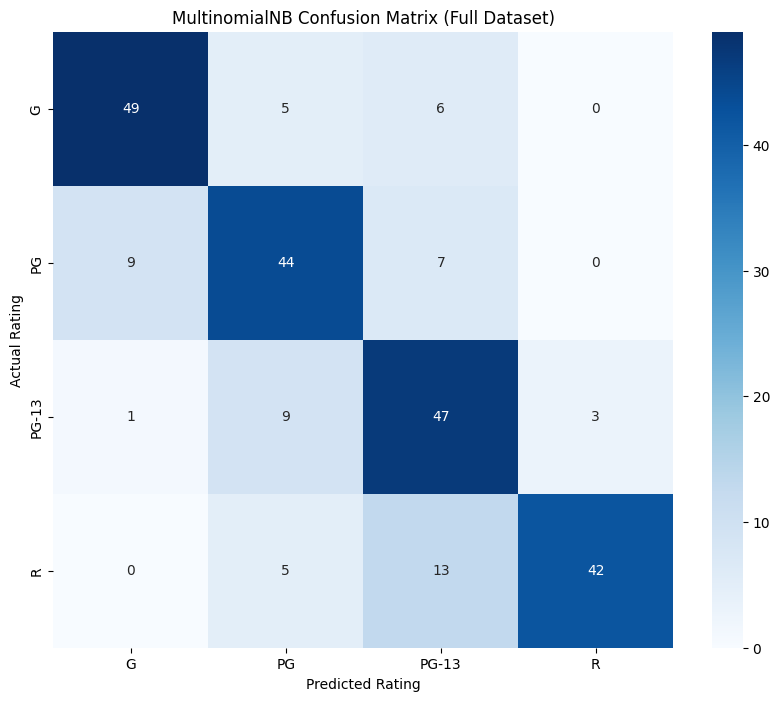


Classification Report:
              precision    recall  f1-score   support

           G     0.8305    0.8167    0.8235        60
          PG     0.6984    0.7333    0.7154        60
       PG-13     0.6438    0.7833    0.7068        60
           R     0.9333    0.7000    0.8000        60

    accuracy                         0.7583       240
   macro avg     0.7765    0.7583    0.7614       240
weighted avg     0.7765    0.7583    0.7614       240


Rule-based method accuracy: 0.4208
MultinomialNB improvement over rule-based: 0.3375

MultinomialNB model and components saved to outputs/ directory

=== Analysis Complete ===


In [6]:
# Improved preprocess_text function with more aggressive cleaning
def preprocess_text(text_content):
    # Handle different input types
    if isinstance(text_content, pd.DataFrame):
        all_text = []
        if 'text' in text_content.columns:
            for _, row in text_content.iterrows():
                if pd.notna(row['text']):
                    all_text.append(str(row['text']))
        raw_text = ' '.join(all_text)
    else:
        # Assume it's already a string
        raw_text = str(text_content)
    
    # Ensure we have some text to process
    if not raw_text or len(raw_text.strip()) < 10:
        return "no text available", 0
    
    # Process text
    text = raw_text.lower()  # case folding
    
    # More aggressive cleaning
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove punctuation
    text = re.sub(r'\d+', ' ', text)      # Remove numbers
    text = re.sub(r'\s+', ' ', text)      # Normalize whitespace
    text = re.sub(r'\b\w{1,2}\b', ' ', text)  # Remove very short words
    text = text.strip()
    
    # Tokenize and remove stopwords
    try:
        tokens = word_tokenize(text)
        stop_words = set(stopwords.words('english'))
        filtered_tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    except:
        # Simple fallback tokenization if NLTK fails
        tokens = text.split()
        filtered_tokens = [word for word in tokens if len(word) > 2]
    
    # Count total words
    total_words = len(filtered_tokens)
    
    # Join back into text
    processed_text = ' '.join(filtered_tokens)
    return processed_text, total_words

# Count keywords by category and severity
def count_words_by_category(text, keywords_df):
    # Initialize counters for each category and severity
    counts = {
        'bad_language_mild': 0,
        'bad_language_moderate': 0,
        'bad_language_severe': 0,
        'sexual_mild': 0,
        'sexual_moderate': 0,
        'sexual_severe': 0,
        'violence_mild': 0,
        'violence_moderate': 0,
        'violence_severe': 0
    }
    
    # Ensure text is lowercase
    text = text.lower()
    
    # Count keyword occurrences with word boundary matching
    for _, keyword in keywords_df.iterrows():
        if 'teks' in keyword and 'kategori' in keyword and 'severity' in keyword:
            word = str(keyword['teks']).lower()
            category = str(keyword['kategori']).lower()
            severity = str(keyword['severity']).lower()
            
            # Skip invalid data
            if not word or not category or not severity:
                continue
                
            # Count occurrences with word boundary
            pattern = r'\b' + re.escape(word) + r'\b'
            occurrences = len(re.findall(pattern, text))
            
            # Add to appropriate counter
            if category == 'bad language' and severity == 'mild':
                counts['bad_language_mild'] += occurrences
            elif category == 'bad language' and severity == 'moderate':
                counts['bad_language_moderate'] += occurrences
            elif category == 'bad language' and severity == 'severe':
                counts['bad_language_severe'] += occurrences
            elif category == 'sexual' and severity == 'mild':
                counts['sexual_mild'] += occurrences
            elif category == 'sexual' and severity == 'moderate':
                counts['sexual_moderate'] += occurrences
            elif category == 'sexual' and severity == 'severe':
                counts['sexual_severe'] += occurrences
            elif category == 'violence' and severity == 'mild':
                counts['violence_mild'] += occurrences
            elif category == 'violence' and severity == 'moderate':
                counts['violence_moderate'] += occurrences
            elif category == 'violence' and severity == 'severe':
                counts['violence_severe'] += occurrences
    
    return counts

# Improved feature extraction with more nuanced weights
def extract_features(content, keywords_df):
    # Process text
    processed_text, total_words = preprocess_text(content)
    
    # Count keywords by category and severity
    counts = count_words_by_category(processed_text, keywords_df)
    
    # Add total words
    counts['total_words'] = total_words if total_words > 0 else 1
    
    # Create normalized features (per 1000 words)
    for key in list(counts.keys()):
        if key != 'total_words':
            counts[f'{key}_norm'] = (counts[key] / counts['total_words']) * 1000
    
    # Add category totals with more nuanced weighting
    counts['bad_language_total'] = counts['bad_language_mild'] + (2 * counts['bad_language_moderate']) + (4 * counts['bad_language_severe'])
    counts['sexual_total'] = counts['sexual_mild'] + (3 * counts['sexual_moderate']) + (5 * counts['sexual_severe'])
    counts['violence_total'] = counts['violence_mild'] + (2 * counts['violence_moderate']) + (4 * counts['violence_severe'])
    
    # Calculate normalized totals
    counts['bad_language_total_norm'] = counts['bad_language_total'] / counts['total_words'] * 1000
    counts['sexual_total_norm'] = counts['sexual_total'] / counts['total_words'] * 1000
    counts['violence_total_norm'] = counts['violence_total'] / counts['total_words'] * 1000
    
    # Calculate severity weighted scores with more weight to severe content
    counts['bad_language_weighted'] = counts['bad_language_mild'] + (4 * counts['bad_language_moderate']) + (8 * counts['bad_language_severe'])
    counts['sexual_weighted'] = counts['sexual_mild'] + (4 * counts['sexual_moderate']) + (10 * counts['sexual_severe'])
    counts['violence_weighted'] = counts['violence_mild'] + (4 * counts['violence_moderate']) + (8 * counts['violence_severe'])
    
    # Normalize weighted scores
    counts['bad_language_weighted_norm'] = counts['bad_language_weighted'] / counts['total_words'] * 1000
    counts['sexual_weighted_norm'] = counts['sexual_weighted'] / counts['total_words'] * 1000
    counts['violence_weighted_norm'] = counts['violence_weighted'] / counts['total_words'] * 1000
    
    # Enhanced combined scores with higher emphasis on sexual content
    counts['combined_score'] = counts['bad_language_weighted'] + (3 * counts['sexual_weighted']) + (2.5 * counts['violence_weighted'])
    counts['combined_score_norm'] = counts['combined_score'] / counts['total_words'] * 1000
    
    # Save processed text
    counts['processed_text'] = processed_text
    
    return counts

# Determine rating based on criteria
def determine_rating(counts):
    """
    Determine film rating based on content metrics using modified criteria:
    G = bad language: kategori mild <10, sexual: 0, violence: kategori mild <10
    PG = bad language: kategori mild <20, sexual: kategori mild <10, violence: kategori mild <20
    PG-13 = bad language: kategori moderate <25 dan severe <10,
            sexual: kategori mild dan moderate <25, violence: kategori moderate <25
    R = bad language: semua kategori >30, sexual: semua kategori >25, 
        violence: semua kategori >25
    """
    # G rating
    if (counts['bad_language_mild'] < 10 and
        counts['sexual_total'] == 0 and
        counts['violence_mild'] < 10):
        return 'G'
    
    # PG rating
    elif (counts['bad_language_mild'] < 20 and
          counts['sexual_mild'] < 10 and
          counts['sexual_moderate'] + counts['sexual_severe'] == 0 and
          counts['violence_mild'] < 20):
        return 'PG'
    
    # PG-13 rating
    elif (counts['bad_language_moderate'] < 29 and
          counts['bad_language_severe'] < 15 and
          counts['sexual_mild'] + counts['sexual_moderate'] < 29 and
          counts['sexual_severe'] == 0 and
          counts['violence_moderate'] < 29):
        return 'PG-13'
    
    # R rating
    else:
        return 'R'

# Process files from directories
def process_files(base_dir, keywords_df, limit_per_rating=None):
    """
    Process movie files from rating-specific directories
    """
    # Define rating categories and corresponding folders
    ratings = ['G', 'PG', 'PG-13', 'R']
    features_list = []
    
    # Check if outputs directory exists 
    if not os.path.exists('outputs'):
        try:
            os.makedirs('outputs', exist_ok=True)
            print("Folder 'outputs' berhasil dibuat.")
        except Exception as e:
            print(f"Gagal membuat folder 'outputs': {e}")
    
    # Process each rating category
    for rating in ratings:
        rating_dir = os.path.join(base_dir, rating)
        
        if not os.path.exists(rating_dir):
            print(f"Warning: Directory {rating_dir} not found. Skipping.")
            continue
        
        # Fokus pada file .srt
        files = glob.glob(os.path.join(rating_dir, '*.srt'))
        
        # Limit files per category if specified
        if limit_per_rating and len(files) > limit_per_rating:
            files = files[:limit_per_rating]
        
        print(f"Found {len(files)} .srt files in {rating} folder")
        
        # Process each file
        for file_path in tqdm(files, desc=f"Processing {rating} files"):
            try:
                # Load content
                content = load_file(file_path)
                if content is None:
                    continue
                
                # Extract features
                features = extract_features(content, keywords_df)
                
                # Add filename and actual rating
                features['filename'] = os.path.basename(file_path)
                features['actual_rating'] = rating
                features['rule_based_rating'] = determine_rating(features)
                
                features_list.append(features)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
    
    # Convert to DataFrame
    if not features_list:
        print("No files were processed successfully.")
        return None
    
    return pd.DataFrame(features_list)

# Development version of add_advanced_features function
def dev_advance_features(features_df):
    """
    Identical to add_advanced_features but with a different name
    for development and testing purposes
    """
    df = features_df.copy()
    
    # Small value to avoid division by zero
    epsilon = 1e-10
    
    # 1. Category ratios with higher weights for severe content
    all_content = (
        df['bad_language_mild'] + (2 * df['bad_language_moderate']) + (5 * df['bad_language_severe']) +
        df['sexual_mild'] + (3 * df['sexual_moderate']) + (8 * df['sexual_severe']) +
        df['violence_mild'] + (2 * df['violence_moderate']) + (5 * df['violence_severe']) + epsilon
    )
    
    df['bad_language_ratio'] = (df['bad_language_mild'] + (2 * df['bad_language_moderate']) + (5 * df['bad_language_severe'])) / all_content
    df['sexual_ratio'] = (df['sexual_mild'] + (3 * df['sexual_moderate']) + (8 * df['sexual_severe'])) / all_content
    df['violence_ratio'] = (df['violence_mild'] + (2 * df['violence_moderate']) + (5 * df['violence_severe'])) / all_content
    
    # 2. Rating-specific indicators (higher value = more likely to be that rating)
    # G rating - very family friendly
    df['g_indicator'] = 10 - (
        (df['sexual_total'] * 10) +  # No sexual content
        (df['bad_language_moderate'] + df['bad_language_severe']) * 5 +
        (df['violence_moderate'] + df['violence_severe']) * 5
    ) / (df['total_words'] + epsilon) * 100
    
    # PG rating - some mild content
    df['pg_indicator'] = 10 - (
        (df['sexual_moderate'] + df['sexual_severe']) * 8 +
        df['bad_language_severe'] * 5 +
        df['violence_severe'] * 5 - 
        (df['bad_language_mild'] + df['violence_mild']) * 0.5  # Some mild content is OK
    ) / (df['total_words'] + epsilon) * 100
    
    # PG-13 rating - moderate content
    df['pg13_indicator'] = 10 - (
        df['sexual_severe'] * 10 -
        (df['bad_language_moderate'] * 0.5) +  # Some moderate language is expected
        (df['bad_language_severe'] - 5) * 2 +  # Some severe language is allowed
        (df['violence_severe'] - 3) * 3 +  # Some violence is allowed
        (df['sexual_moderate'] - 2) * 2  # Some sexual references allowed
    ) / (df['total_words'] + epsilon) * 100
    
    # R rating - adult content
    df['r_indicator'] = (
        df['sexual_severe'] * 10 +
        (df['bad_language_severe'] - 5) * 2 +
        (df['violence_severe'] - 3) * 3 +
        df['sexual_total'] * 2
    ) / (df['total_words'] + epsilon) * 100
    
    # Clip indicators to 0-10 range
    for col in ['g_indicator', 'pg_indicator', 'pg13_indicator', 'r_indicator']:
        df[col] = df[col].clip(0, 10)
    
    # 3. Binary indicators for classification
    df['has_severe_language'] = (df['bad_language_severe'] > 0).astype(int)
    df['has_moderate_language'] = (df['bad_language_moderate'] > 0).astype(int)
    df['has_any_sexual'] = (df['sexual_total'] > 0).astype(int)
    df['has_severe_sexual'] = (df['sexual_severe'] > 0).astype(int)
    df['has_moderate_sexual'] = (df['sexual_moderate'] > 0).astype(int)
    df['has_severe_violence'] = (df['violence_severe'] > 0).astype(int)
    df['has_moderate_violence'] = (df['violence_moderate'] > 0).astype(int)
    
    # 4. Content density (per thousand words)
    df['severe_content_density'] = (
        df['bad_language_severe'] + df['sexual_severe'] + df['violence_severe']
    ) / (df['total_words'] + epsilon) * 1000
    
    df['moderate_content_density'] = (
        df['bad_language_moderate'] + df['sexual_moderate'] + df['violence_moderate']
    ) / (df['total_words'] + epsilon) * 1000
    
    # 5. Rating boundary features - FIXED to use proper elementwise operations
    # G-PG boundary (fixed to use bitwise operator | instead of logical or)
    df['g_pg_boundary'] = (
        (df['bad_language_mild'] > 5) | 
        (df['violence_mild'] > 5) | 
        (df['sexual_mild'] > 0)
    ).astype(int)
    
    # PG-PG13 boundary
    df['pg_pg13_boundary'] = (
        (df['bad_language_moderate'] > 5) | 
        (df['violence_moderate'] > 5) | 
        (df['sexual_moderate'] > 0) | 
        (df['bad_language_severe'] > 0)
    ).astype(int)
    
    # PG13-R boundary
    df['pg13_r_boundary'] = (
        (df['bad_language_severe'] > 10) | 
        (df['violence_severe'] > 5) | 
        (df['sexual_severe'] > 0) | 
        (df['sexual_moderate'] > 10)
    ).astype(int)
    
    # 6. Interactions between content types (important for ratings)
    df['sexual_violence_interaction'] = df['sexual_total_norm'] * df['violence_total_norm'] / 1000
    df['language_sexual_interaction'] = df['bad_language_total_norm'] * df['sexual_total_norm'] / 1000
    
    # 7. Log transforms for better scaling
    for col in ['bad_language_total', 'sexual_total', 'violence_total']:
        df[f'{col}_log'] = np.log1p(df[col])
    
    # 8. Content type counts (number of different sensitive content types)
    df['content_type_count'] = (
        (df['bad_language_total'] > 0).astype(int) +
        (df['sexual_total'] > 0).astype(int) +
        (df['violence_total'] > 0).astype(int)
    )
    
    # 9. Severity level counts (number of different severity levels)
    df['severe_type_count'] = (
        (df['bad_language_severe'] > 0).astype(int) +
        (df['sexual_severe'] > 0).astype(int) +
        (df['violence_severe'] > 0).astype(int)
    )
    
    # 10. Combined severe-moderate ratio
    all_severe_moderate = (
        df['bad_language_severe'] + df['sexual_severe'] + df['violence_severe'] +
        df['bad_language_moderate'] + df['sexual_moderate'] + df['violence_moderate'] + epsilon
    )
    
    df['severe_content_ratio'] = (
        df['bad_language_severe'] + df['sexual_severe'] + df['violence_severe']
    ) / all_severe_moderate
    
    # 11. Additional rating-specific features to improve separation
    # R vs PG-13 distinction
    df['r_vs_pg13'] = (
        (df['sexual_severe'] > 0).astype(int) * 5 + 
        (df['bad_language_severe'] > 15).astype(int) * 3 + 
        (df['violence_severe'] > 8).astype(int) * 3
    )
    
    # PG vs G distinction
    df['pg_vs_g'] = (
        (df['sexual_mild'] > 0).astype(int) * 3 + 
        (df['bad_language_mild'] > 8).astype(int) * 2 + 
        (df['violence_mild'] > 8).astype(int) * 2
    )
    
    # 12. Content type mixtures (important for ratings)
    # Sexual + violent content is often associated with R ratings
    df['sexual_violent_mixture'] = np.sqrt((df['sexual_total'] * df['violence_total']) / (df['total_words'] + epsilon)) * 10
    
    # 13. Rating predictions based on individual content types
    # 0 = G, 1 = PG, 2 = PG-13, 3 = R
    df['language_rating_score'] = (
        (df['bad_language_mild'] > 0).astype(int) * 1 + 
        (df['bad_language_moderate'] > 0).astype(int) * 1 + 
        (df['bad_language_severe'] > 0).astype(int) * 1
    ).clip(0, 3)
    
    df['sexual_rating_score'] = (
        (df['sexual_mild'] > 0).astype(int) * 1 + 
        (df['sexual_moderate'] > 0).astype(int) * 1 + 
        (df['sexual_severe'] > 0).astype(int) * 3  # Sexual severe content almost always indicates R
    ).clip(0, 3)
    
    df['violence_rating_score'] = (
        (df['violence_mild'] > 0).astype(int) * 1 + 
        (df['violence_moderate'] > 0).astype(int) * 1 + 
        (df['violence_severe'] > 8).astype(int) * 1  # Higher threshold for violence
    ).clip(0, 3)
    
    print(f"Added {len(df.columns) - len(features_df.columns)} advanced features")
    
    return df

# Generate confusion matrix visualization
def generate_confusion_matrix(y_true, y_pred, class_names, title, filename):
    """
    Generate and display a confusion matrix
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        class_names: List of class names for the labels
        title: Title for the plot
        filename: Output filename for the saved image
    """
    print(f"\n=== {title} ===")
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create DataFrame for better display in console
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    print("\nConfusion Matrix Values:")
    print(cm_df)
    
    # Calculate per-class accuracy
    print("\nPer-class Accuracy:")
    for i, class_name in enumerate(class_names):
        class_indices = (y_true == i)
        if sum(class_indices) > 0:  # Avoid division by zero
            class_accuracy = accuracy_score(y_true[class_indices], y_pred[class_indices])
            print(f"{class_name}: {class_accuracy:.4f} ({sum(class_indices)} samples)")
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted Rating')
    plt.ylabel('Actual Rating')
    plt.title(title)
    
    # Output directory
    os.makedirs('outputs', exist_ok=True)
    
    # Save the plot
    plt.savefig(f'outputs/{filename}', dpi=300, bbox_inches='tight')
    print(f"Confusion matrix plot saved to outputs/{filename}")
    
    # Display the plot if possible
    try:
        plt.show()
    except Exception as e:
        print(f"Warning: Couldn't display plot: {e}")
    plt.close()
    
    # Print classification report
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    print("\nClassification Report:")
    print(report)

# Main function focusing only on MultinomialNB
def main():
    print("=== Film Content Rating Classification with MultinomialNB and dev_advance_features ===")

    # Find file paths
    keywords_path, base_dir = find_paths()

    # Load keywords
    keywords_df = load_keywords(keywords_path)

    # Process files from directories - use all available files per rating
    features_df = process_files(base_dir, keywords_df)
    
    # Add advanced features using dev_advance_features
    features_df = dev_advance_features(features_df)
    
    # Create target variable
    features_df['rating_encoded'] = features_df['actual_rating'].map({'G': 0, 'PG': 1, 'PG-13': 2, 'R': 3})
    
    # Define rating order for consistent reference
    rating_classes = ['G', 'PG', 'PG-13', 'R']
    
    # Show dataset distribution
    print("\nDataset distribution:")
    rating_counts = features_df['actual_rating'].value_counts()
    print(rating_counts)
    
    # Use the entire dataset for training
    X = features_df.copy()
    y = features_df['rating_encoded']
    print(f"\nUsing full dataset for training: {len(X)} samples")
    
    # Select content features for the model
    content_features = [
        # Base normalized features
        'bad_language_total_norm', 'sexual_total_norm', 'violence_total_norm',
        'bad_language_severe_norm', 'sexual_severe_norm', 'violence_severe_norm',
        
        # Rating indicators (these directly model each rating)
        'g_indicator', 'pg_indicator', 'pg13_indicator', 'r_indicator',
        
        # Binary flags for severe content (strong predictors)
        'has_severe_language', 'has_severe_sexual', 'has_severe_violence', 
        'has_any_sexual',
        
        # Content density features (normalized by text length)
        'severe_content_density', 'moderate_content_density',
        
        # Rating boundary features (transition points between ratings)
        'g_pg_boundary', 'pg_pg13_boundary', 'pg13_r_boundary',
        
        # Content interaction features
        'sexual_violence_interaction', 'sexual_violent_mixture',
        
        # Ratio features (proportional content)
        'bad_language_ratio', 'sexual_ratio', 'violence_ratio',
        'severe_content_ratio',
        
        # Rating differentiation features
        'r_vs_pg13', 'pg_vs_g'
    ]
    
    # Verify features exist in the data
    content_features = [f for f in content_features if f in X.columns]
    print(f"\nUsing {len(content_features)} content features")
    
    # Extract text features
    print("\nExtracting text features with TF-IDF...")
    tfidf = TfidfVectorizer(
        min_df=3,           # Ignore very rare terms
        max_df=0.8,         # Ignore common terms
        ngram_range=(1, 2), # Use unigrams and bigrams
        stop_words='english',
        max_features=200,   # Increase feature representation
        norm='l2',          # Use L2 normalization
        use_idf=True        # Use inverse document frequency
    )
    X_text = tfidf.fit_transform(X['processed_text'])
    
    # Extract content features
    print("Extracting content features...")
    X_content = X[content_features].fillna(0).values
    
    # Scale content features
    scaler = MinMaxScaler()
    X_content_scaled = scaler.fit_transform(X_content)
    
    # Combine features
    from scipy.sparse import hstack, csr_matrix
    X_content_sparse = csr_matrix(X_content_scaled)
    X_combined = hstack([X_text, X_content_sparse])
    
    # Find optimal alpha for MultinomialNB
    print("\nFinding optimal hyperparameters for MultinomialNB...")
    
    # Define parameter grid for MultinomialNB
    param_grid_nb = {
        'alpha': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0]
    }
    
    # Create grid search with cross-validation
    grid_nb = GridSearchCV(
        MultinomialNB(),
        param_grid_nb,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit grid search to find best parameters
    grid_nb.fit(X_combined, y)
    
    # Get best parameters
    best_alpha = grid_nb.best_params_['alpha']
    print(f"\nBest alpha value for MultinomialNB: {best_alpha}")
    print(f"Cross-validation accuracy: {grid_nb.best_score_:.4f}")
    
    # Create optimal MultinomialNB model
    nb_model = MultinomialNB(alpha=best_alpha)
    print("\nTraining MultinomialNB model with optimal alpha on full dataset...")
    nb_model.fit(X_combined, y)
    
    # Evaluate the model on the full dataset (in-sample accuracy)
    print("\nEvaluating MultinomialNB on full dataset...")
    y_pred = nb_model.predict(X_combined)
    accuracy = accuracy_score(y, y_pred)
    print(f"MultinomialNB in-sample accuracy: {accuracy:.4f}")
    
    # Generate confusion matrix for the full dataset
    generate_confusion_matrix(
        y, 
        y_pred, 
        rating_classes,
        "MultinomialNB Confusion Matrix (Full Dataset)",
        "nb_full_dataset_confusion_matrix.png"
    )
    
    # Compare with rule-based method
    rule_based_preds = X['rule_based_rating'].map({'G': 0, 'PG': 1, 'PG-13': 2, 'R': 3})
    rule_based_acc = accuracy_score(y, rule_based_preds)
    print(f"\nRule-based method accuracy: {rule_based_acc:.4f}")
    print(f"MultinomialNB improvement over rule-based: {accuracy - rule_based_acc:.4f}")
    
    # Save the MultinomialNB model and components
    try:
        os.makedirs('outputs', exist_ok=True)
        joblib.dump(nb_model, 'outputs/multinomialNB_model.pkl')
        joblib.dump(tfidf, 'outputs/tfidf_vectorizer.pkl')
        joblib.dump(scaler, 'outputs/content_scaler.pkl')
        joblib.dump(content_features, 'outputs/content_features.pkl')
        print("\nMultinomialNB model and components saved to outputs/ directory")
    except Exception as e:
        print(f"Error saving model: {e}")
    
    print("\n=== Analysis Complete ===")
    return nb_model, tfidf, scaler, content_features

if __name__ == "__main__":
    main()

In [7]:
!zip -r outputs.zip /kaggle/working/outputs

  adding: kaggle/working/outputs/ (stored 0%)
  adding: kaggle/working/outputs/multinomialNB_model.pkl (deflated 7%)
  adding: kaggle/working/outputs/tfidf_vectorizer.pkl (deflated 55%)
  adding: kaggle/working/outputs/nb_full_dataset_confusion_matrix.png (deflated 26%)
  adding: kaggle/working/outputs/content_scaler.pkl (deflated 62%)
  adding: kaggle/working/outputs/content_features.pkl (deflated 56%)


In [8]:
from IPython.display import FileLink
FileLink(r'outputs.zip')

/kaggle/working/outputs.zip